In [74]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Subset
import random
import numpy as np
import os
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import copy
import pickle

In [75]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [76]:
def plot_weight_histograms(model, title):
    weights = []
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            weights.append(module.weight.detach().cpu().numpy().flatten())
    plt.figure(figsize=(15, 8))
    for i, w in enumerate(weights[:11]):
        plt.subplot(5, 6, i + 1)
        plt.hist(w, bins=40, color='blue', alpha=0.7)
        plt.title(f"Layer {i+1}")
        plt.tight_layout()
    plt.suptitle(title, y=1)
    plt.show()

In [77]:
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11.classifier[6] = torch.nn.Linear(4096, 100)
vgg11.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
vgg11.load_state_dict(torch.load('models/vgg11_cifar100_baseline_5e.pt', weights_only=True, map_location=device))
vgg11.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [78]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
NUM_WORKERS = 4

g = torch.Generator()
g.manual_seed(42)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
full_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)
_, small_test_subset = random_split(full_test, [7500, 2500], generator=g)
train_subset, val_subset = random_split(full_train, [45000, 5000], generator=g)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform
full_test.transform = test_transform
small_test_subset.transform = test_transform

print("Training set size:", len(train_subset))
print("Validation set size:", len(val_subset))
print("Test Set Size:", len(full_test))
print("Small Test Size:", len(small_test_subset))

def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_subset, shuffle=True)
val_loader = get_loader(val_subset, shuffle=False)
test_loader = get_loader(full_test, shuffle=False)
small_test_loader = get_loader(small_test_subset, shuffle=False)

Training set size: 47500
Validation set size: 2500
Test set size: 10000


In [79]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [80]:
def prune_layer_structured_L2(model, target_layer, amount=0.3):
    """
    Performs structured channel-wise pruning on a Conv2d layer.
    Prunes entire output channels with smallest L2-norms, and adjusts the next Conv2d layer.
    """
    # Convert layer name (like "features.3") to module reference
    modules = dict(model.named_modules())
    if target_layer not in modules or not isinstance(modules[target_layer], torch.nn.Conv2d):
        print(f"Skipping {target_layer} (not Conv2d)")
        return model

    conv = modules[target_layer]
    with torch.no_grad():
        # Compute L2 norm of each output channel (filter)
        weight = conv.weight.data
        out_channels = weight.shape[0]
        num_prune = int(amount * out_channels)
        if num_prune == 0:
            return model

        norms = torch.norm(weight.view(out_channels, -1), p=2, dim=1)
        prune_idx = torch.argsort(norms)[:num_prune]
        keep_idx = torch.argsort(norms)[num_prune:]

        # Prune current layer (reduce output channels)
        conv.weight = torch.nn.Parameter(weight[keep_idx].clone())
        if conv.bias is not None:
            conv.bias = torch.nn.Parameter(conv.bias.data[keep_idx].clone())
        conv.out_channels = len(keep_idx)

        # Find the next Conv2d and prune corresponding input channels
        found = False
        prev_name = target_layer
        for name, module in modules.items():
            if found and isinstance(module, torch.nn.Conv2d):
                next_conv = module
                next_weight = next_conv.weight.data[:, keep_idx, :, :].clone()
                next_conv.weight = torch.nn.Parameter(next_weight)
                next_conv.in_channels = len(keep_idx)
                break
            if name == target_layer:
                found = True

    return model


In [81]:
conv_layers = [name for name, module in vgg11.named_modules() if isinstance(module, torch.nn.Conv2d)]

prune_amts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]  # better scale for structured pruning
sensitivity_dict = {}
for layer in conv_layers:
    print(f"Layer {layer}")
    for perc in prune_amts:
        vgg11_copy = copy.deepcopy(vgg11)
        pruned_model = prune_layer_structured_L2(vgg11_copy, layer, perc)
        acc = evaluate(pruned_model, small_test_loader, device)
        print(f"{perc*100:.0f}% channel pruning: {acc:.2f}% Accuracy")
        sensitivity_dict[(layer, perc)] = acc

Layer features.0 with 0% channel pruning: 73.10% Accuracy
Layer features.0 with 10% channel pruning: 73.60% Accuracy
Layer features.0 with 20% channel pruning: 72.45% Accuracy
Layer features.0 with 30% channel pruning: 70.70% Accuracy
Layer features.0 with 40% channel pruning: 67.80% Accuracy
Layer features.0 with 50% channel pruning: 61.05% Accuracy
Layer features.0 with 60% channel pruning: 51.40% Accuracy
Layer features.0 with 70% channel pruning: 42.70% Accuracy
Layer features.0 with 90% channel pruning: 10.55% Accuracy
Layer features.3 with 0% channel pruning: 73.55% Accuracy
Layer features.3 with 10% channel pruning: 72.65% Accuracy
Layer features.3 with 20% channel pruning: 72.95% Accuracy
Layer features.3 with 30% channel pruning: 71.50% Accuracy
Layer features.3 with 40% channel pruning: 70.25% Accuracy
Layer features.3 with 50% channel pruning: 68.30% Accuracy
Layer features.3 with 60% channel pruning: 64.70% Accuracy
Layer features.3 with 70% channel pruning: 59.65% Accuracy

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x22589 and 25088x4096)

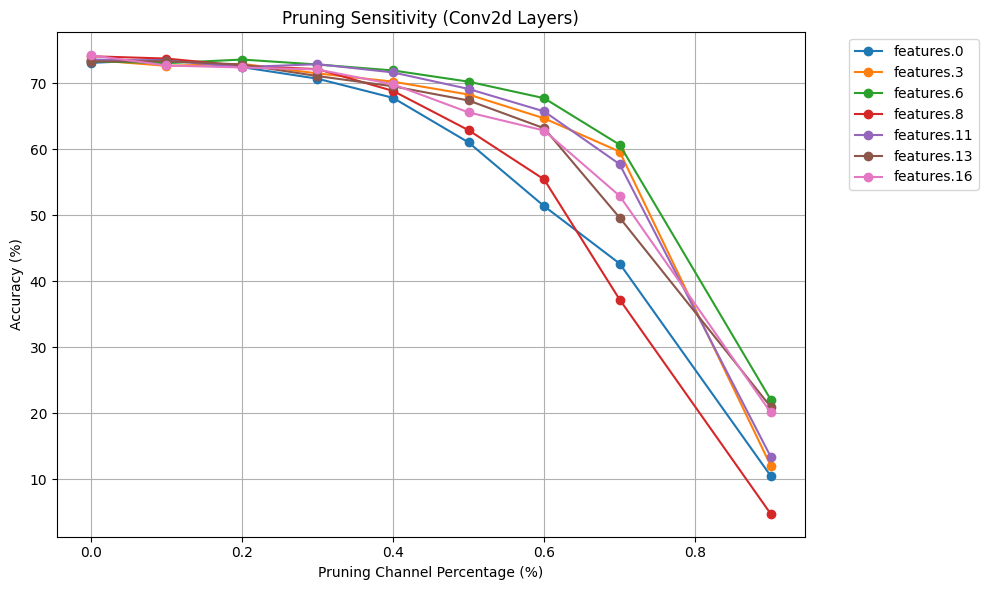

In [91]:
# --- Plot for Conv layers ---
plt.figure(figsize=(10, 6))
for layer in conv_layers[:-1]:
    accs = [sensitivity_dict.get((layer, p))*100 for p in prune_amts]
    plt.plot(prune_amts, accs, marker='o', label=layer)

plt.title("Pruning Sensitivity (Conv2d Layers)")
plt.xlabel("Pruning Channel Percentage (%)")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
# Save the dictionary to a file
with open('sensitivity_dict_structured.pkl', 'wb') as f:
    pickle.dump(sensitivity_dict, f)